In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import KMeans

In [2]:
# Load dataset
def load_data(file_path):
    return pd.read_csv(file_path)

In [3]:
# Clean weather-related columns
def clean_weather_data(df):
    weather_cols = ['Start_Time', 'Start_Lng', 'Sunrise_Sunset', 'Start_Lat', 'Weather_Condition', 'Temperature(F)', 'Wind_Speed(mph)', 
                    'Visibility(mi)', 'Precipitation(in)', 'Humidity(%)', 'Severity']
    df = df[weather_cols].dropna()
    return df

In [4]:
def filter_severe_accidents(df):
    # Ensure 'Severity' column exists
    if 'Severity' in df.columns:
        # Filter the DataFrame to include only severe accidents with Severity 3 or 4
        severe_df = df[df['Severity'].isin([3, 4])]
        return severe_df
    else:
        raise KeyError("The DataFrame does not contain a 'Severity' column.")

In [5]:
def analyze_weather_vs_severity(df):
    # Group by 'Weather_Condition' and sum up the accident counts
    weather_counts = df['Weather_Condition'].value_counts().nlargest(8)
    
    # Filter the original DataFrame to include only the top 8 weather conditions
    top_weather_conditions = weather_counts.index
    filtered_df = df[df['Weather_Condition'].isin(top_weather_conditions)]
    
    # Group by 'Weather_Condition' and 'Severity', then unstack
    weather_severity = filtered_df.groupby(['Weather_Condition', 'Severity']).size().unstack(fill_value=0)
    
    # Plot the data
    weather_severity.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title("Impact of Weather Conditions on Accident Severity")
    plt.xlabel("Weather Condition")
    plt.ylabel("Accident Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
def analyze_temperature_ranges(df):
    bins = [-10, 32, 50, 70, 90, 120]
    labels = ['Very Cold', 'Cold', 'Moderate', 'Warm', 'Hot']
    df['Temp_Range'] = pd.cut(df['Temperature(F)'], bins=bins, labels=labels)
    temp_counts = df['Temp_Range'].value_counts().sort_index()
    temp_counts.plot(kind='bar', color='skyblue', figsize=(8, 5))
    plt.title("Accidents by Temperature Range")
    plt.xlabel("Temperature Range")
    plt.ylabel("Accident Count")
    plt.tight_layout()
    plt.show()

In [7]:
def analyze_weather_time_of_day(df):
    # Convert 'Start_Time' to datetime, coercing errors to NaT
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    
    # Drop rows where 'Start_Time' conversion resulted in NaT
    df = df.dropna(subset=['Start_Time'])
    
    # Extract the hour from 'Start_Time'
    df['Hour'] = df['Start_Time'].dt.hour
    
    # Determine the top 5 weather conditions by accident count
    top_weather_conditions = df['Weather_Condition'].value_counts().nlargest(5).index
    
    # Filter the DataFrame to include only the top 5 weather conditions
    df_top_weather = df[df['Weather_Condition'].isin(top_weather_conditions)]
    
    # Group by 'Weather_Condition' and 'Hour', then unstack
    weather_hour = df_top_weather.groupby(['Weather_Condition', 'Hour']).size().unstack(fill_value=0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(weather_hour, cmap="YlGnBu", linewidths=0.5)
    plt.title("Accidents by Top 5 Weather Conditions and Time of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Weather Condition")
    plt.tight_layout()
    plt.show()

In [8]:
def analyze_visibility(df):
    # Define bins and labels for visibility ranges
    bins = [0, 1, 3, 5, 10, 20, 50]
    labels = ['Very Low', 'Low', 'Moderate', 'Good', 'Very Good', 'Excellent']
    
    # Create a new column 'Visibility_Range' based on the bins
    df['Visibility_Range'] = pd.cut(df['Visibility(mi)'], bins=bins, labels=labels)
    
    # Count the number of accidents in each visibility range
    visibility_counts = df['Visibility_Range'].value_counts().sort_index()
    
    # Plot the results
    plt.figure(figsize=(8, 5))
    visibility_counts.plot(kind='bar', color='purple')
    plt.title("Accidents by Visibility Range")
    plt.xlabel("Visibility Range")
    plt.ylabel("Accident Count")
    plt.tight_layout()
    plt.show()

In [9]:
def analyze_precipitation(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Precipitation(in)', y='Severity', data=df, alpha=0.5)
    plt.title("Precipitation vs. Accident Severity")
    plt.xlabel("Precipitation (in)")
    plt.ylabel("Severity")
    plt.tight_layout()
    plt.show()

In [10]:
def wind_speed_analysis(df):
   if 'Wind_Speed(mph)' in df.columns:
        wind_speed_severity = df.groupby(pd.cut(df['Wind_Speed(mph)'], bins=[0, 5, 10, 15, 20, 30])).Severity.mean()
        
        wind_speed_severity.plot(kind='bar', color='skyblue')

        plt.title('Impact of Wind Speed on Accident Severity')
        plt.xlabel('Wind Speed (mph)')
        plt.ylabel('Average Severity')

        plt.tight_layout()

        plt.show()

In [11]:
def map_weather_conditions(df):
    # Convert DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Start_Lng'], df['Start_Lat']))

    # Create a new plot with Cartopy
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add natural features like coastlines and borders
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot accident points on top of the map
    gdf.plot(ax=ax, color='blue', alpha=0.5, markersize=1, transform=ccrs.PlateCarree())

    plt.title("Geospatial Distribution of Accidents by Weather Condition")
    plt.tight_layout()
    plt.show()

In [12]:
def analyze_monthly_accidents(df):
    # Convert 'Start_Time' to datetime, coercing errors to NaT
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    
    # Drop rows where 'Start_Time' conversion resulted in NaT
    df = df.dropna(subset=['Start_Time'])
    
    df['Month'] = pd.to_datetime(df['Start_Time']).dt.month
    monthly_counts = df.groupby('Month').size()
    monthly_severity = df.groupby('Month')['Severity'].mean()

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(monthly_counts.index, monthly_counts.values, color='b', alpha=0.6, label='Number of Accidents')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of Accidents', color='b')
    
    ax2 = ax1.twinx()
    ax2.plot(monthly_severity.index, monthly_severity.values, color='r', marker='o', label='Average Severity')
    ax2.set_ylabel('Average Severity', color='r')

    plt.title('Monthly Analysis of Accidents and Severity')
    fig.tight_layout()
    plt.show()

In [13]:
def daily_accident_trends(df):
    df['Date'] = pd.to_datetime(df['Start_Time']).dt.date
    daily_counts = df.groupby('Date').size()

    plt.figure(figsize=(14, 6))
    daily_counts.plot()
    plt.title('Daily Accident Trends')
    plt.xlabel('Date')
    plt.ylabel('Number of Accidents')
    plt.tight_layout()
    plt.show()

In [14]:
def weather_correlation_matrix(df):
    weather_data = df[['Temperature(F)', 'Visibility(mi)', 'Precipitation(in)', 'Severity']]
    corr_matrix = weather_data.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Weather Features and Severity')
    plt.tight_layout()
    plt.show()

In [15]:
def geospatial_clustering(df):
    coords = df[['Start_Lng', 'Start_Lat']]
    
    kmeans = KMeans(n_clusters=5)
    clusters = kmeans.fit_predict(coords)

    df['Cluster'] = clusters

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Start_Lng', y='Start_Lat', hue='Cluster', data=df, palette='viridis', s=10)
    
    plt.title('Geospatial Clustering of Accidents')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()

In [16]:
def boxplot_weather_severity(df):
    # Determine the top 10 weather conditions by accident count
    top_weather_conditions = df['Weather_Condition'].value_counts().nlargest(10).index

    # Filter the DataFrame to include only the top 10 weather conditions
    df_top_weather = df[df['Weather_Condition'].isin(top_weather_conditions)]

    # Create the box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Weather_Condition', y='Severity', data=df_top_weather)

    plt.xticks(rotation=45)
    plt.title('Severity Distribution Across Top 10 Weather Conditions')
    plt.tight_layout()
    plt.show()

def boxplot_worst_weather_severity(df):
    # Define a list of known hazardous weather conditions
    worst_weather_conditions = [
        'Rain', 'Snow', 'Sleet', 'Fog', 'Ice', 'Hail', 'Thunderstorm', 
        'Blizzard', 'Freezing Rain', 'Heavy Rain'
    ]
    
    # Filter the DataFrame to include only these worst weather conditions
    df_worst_weather = df[df['Weather_Condition'].isin(worst_weather_conditions)]

    # Create the box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Weather_Condition', y='Severity', data=df_worst_weather)
    
    plt.xticks(rotation=45)
    plt.title('Severity Distribution Across Worst Weather Conditions')
    plt.tight_layout()
    plt.show()

In [17]:
def day_night_accident_comparison(df):
   if 'Sunrise_Sunset' in df.columns:
        day_night_counts = df.groupby(['Sunrise_Sunset']).size()

        day_night_counts.plot(kind='bar', color=['orange', 'navy'])

        plt.title('Day vs Night Accidents by Weather Condition')

        plt.xlabel('Time of Day')

        plt.ylabel('Number of Accidents')

        plt.xticks(rotation=0)

        plt.tight_layout()

        plt.show()

In [18]:
def temperature_humidity_interaction(df):
   if 'Humidity(%)' in df.columns:
        # Construct dataset for plotting
        temp_humidity_df = df[['Temperature(F)', 'Humidity(%)', 'Severity']]

        # Create a joint plot with hexagonal bins
        plt.figure(figsize=(10, 7))
        joint_plot = sns.jointplot(x='Temperature(F)', y='Humidity(%)', data=temp_humidity_df, kind='hex', gridsize=30)

        # Set titles and labels
        joint_plot.fig.suptitle('Joint Analysis of Temperature and Humidity Effects on Accident Severity', y=1.05)
        joint_plot.set_axis_labels('Temperature (°F)', 'Humidity (%)')

        # Add a color bar indicating point density
        plt.colorbar(label='Point Density')

        plt.tight_layout()
        plt.show()

In [19]:
def severity_distribution_map(df):
   if {'Start_Lng', 'Start_Lat'}.issubset(df.columns):
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Start_Lng'], df['Start_Lat']))

        fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

        ax.add_feature(cfeature.COASTLINE)

        ax.add_feature(cfeature.BORDERS)

        gdf.plot(ax=ax, column='Severity', cmap='OrRd', legend=True, markersize=5)

        ax.set_title("Severity Distribution by Region")

        ax.set_extent([-130, -65, 20, 55]) # Rough extent for continental US
        
        fig.tight_layout()

        plt.show()

In [20]:
file_path = "./dataset.csv"

In [21]:
df = load_data(file_path)

In [22]:
df = clean_weather_data(df)

In [23]:
df_severe = filter_severe_accidents(df)

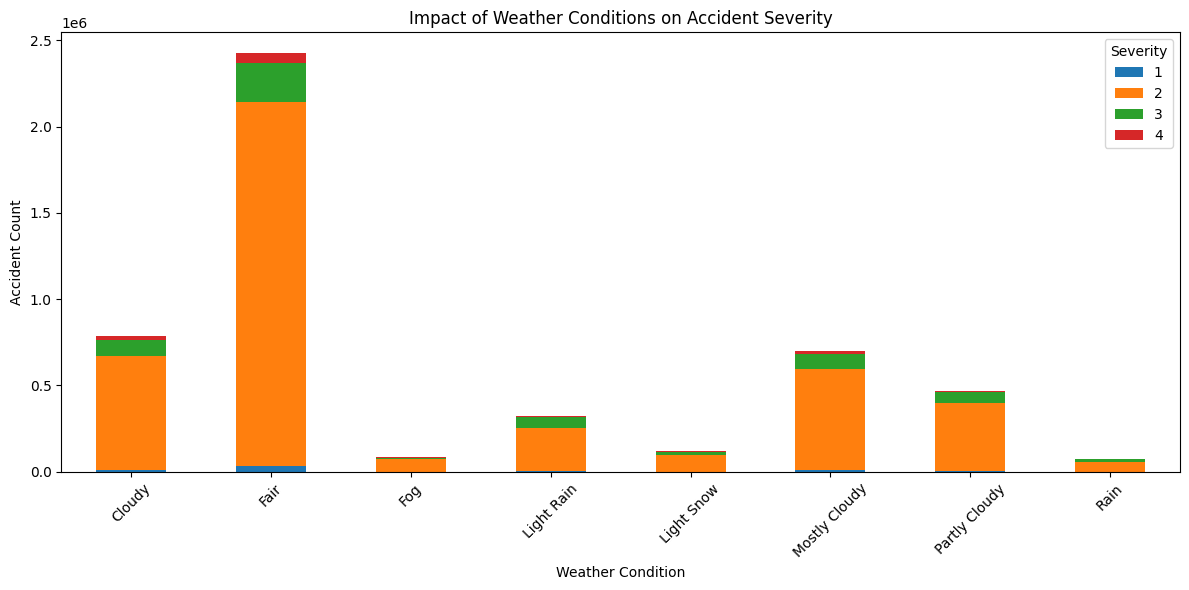

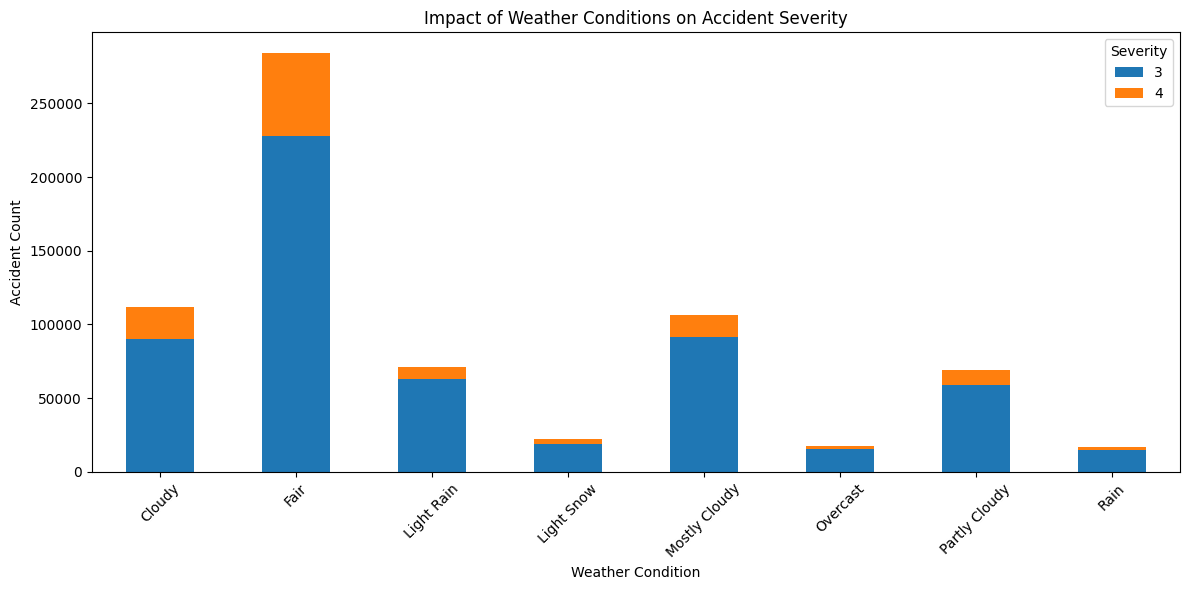

In [24]:
analyze_weather_vs_severity(df)
analyze_weather_vs_severity(df_severe)

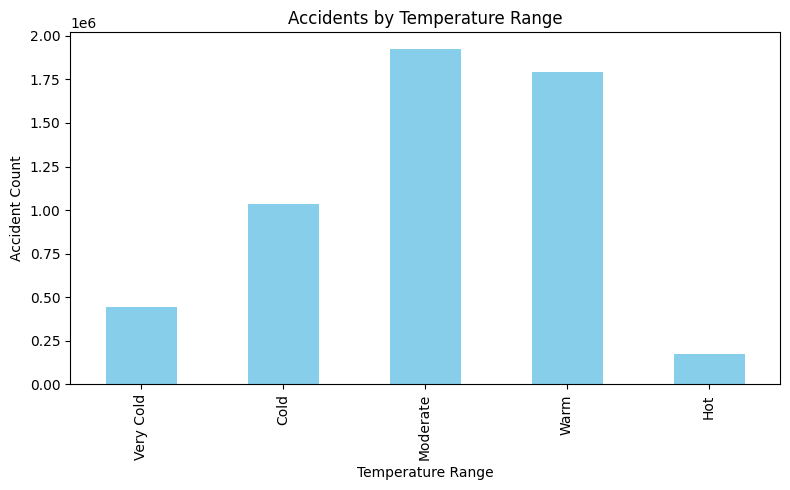

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\1766481202.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temp_Range'] = pd.cut(df['Temperature(F)'], bins=bins, labels=labels)


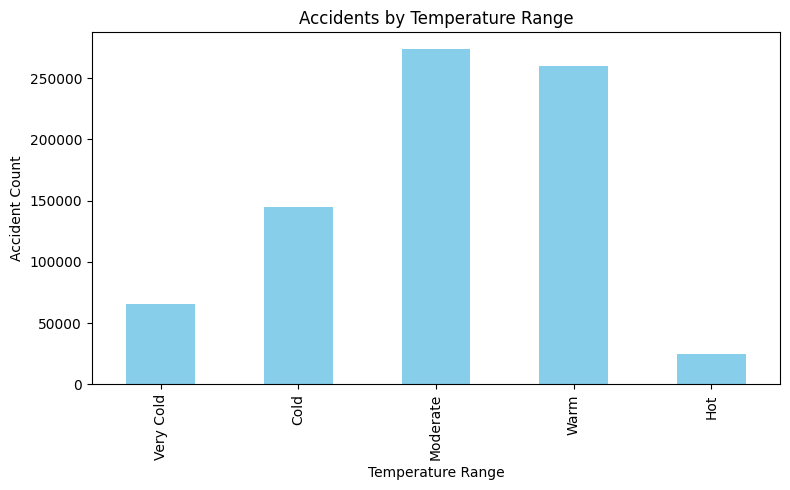

In [25]:
analyze_temperature_ranges(df)
analyze_temperature_ranges(df_severe)

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\434019197.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Start_Time'].dt.hour


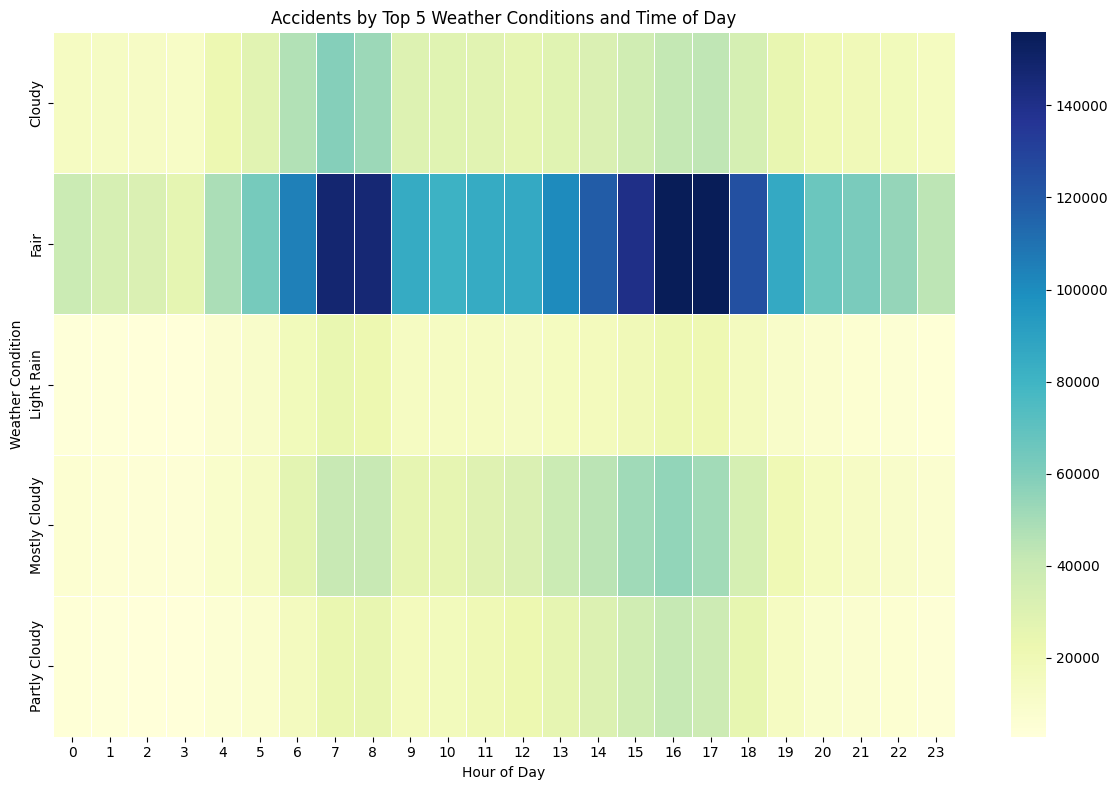

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\434019197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\434019197.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Start_Time'].dt.hour


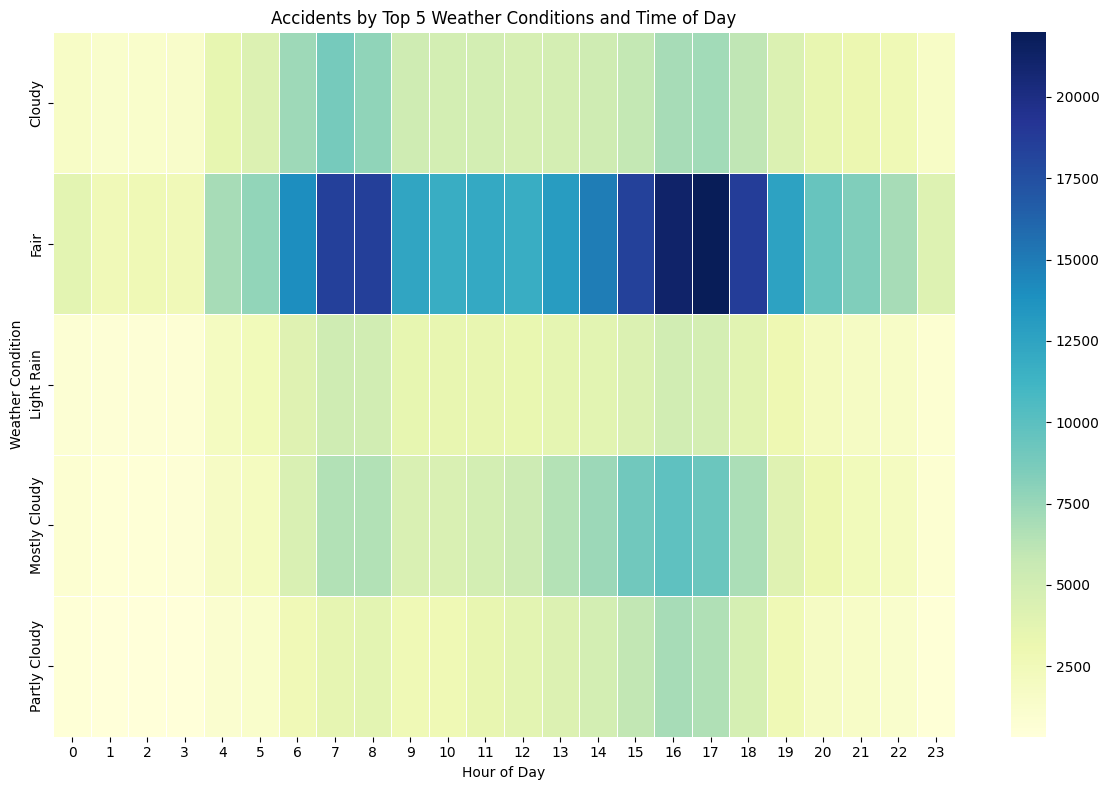

In [26]:
analyze_weather_time_of_day(df)
analyze_weather_time_of_day(df_severe)

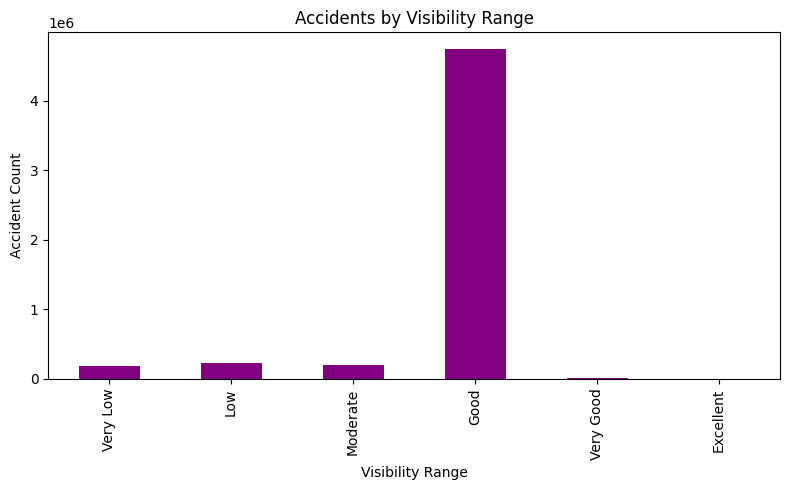

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\725085201.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Visibility_Range'] = pd.cut(df['Visibility(mi)'], bins=bins, labels=labels)


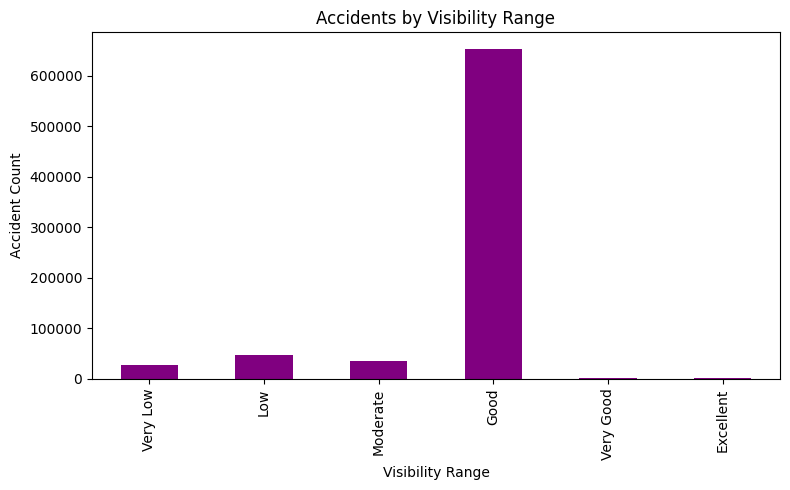

In [27]:
analyze_visibility(df)
analyze_visibility(df_severe)

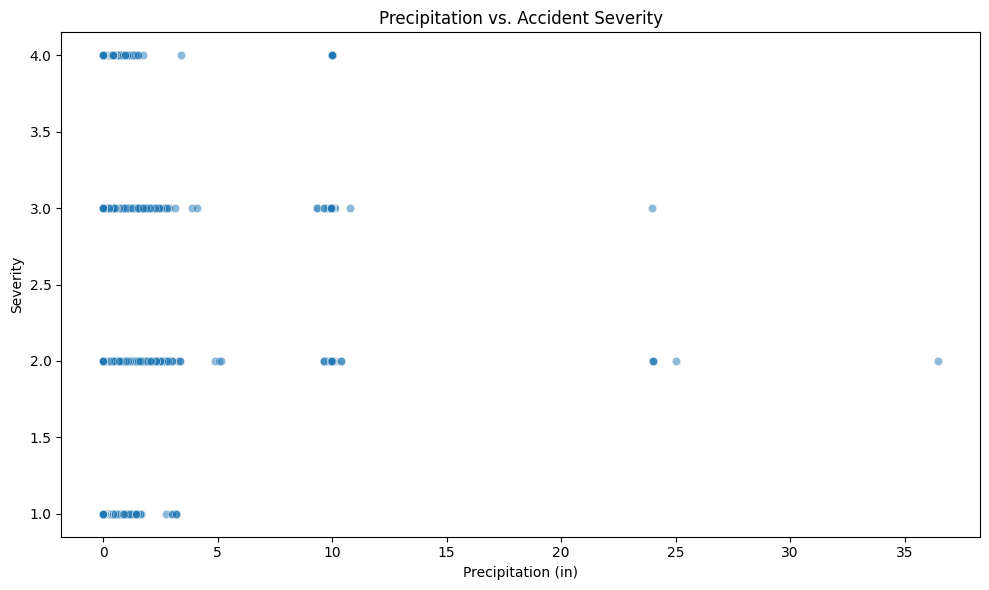

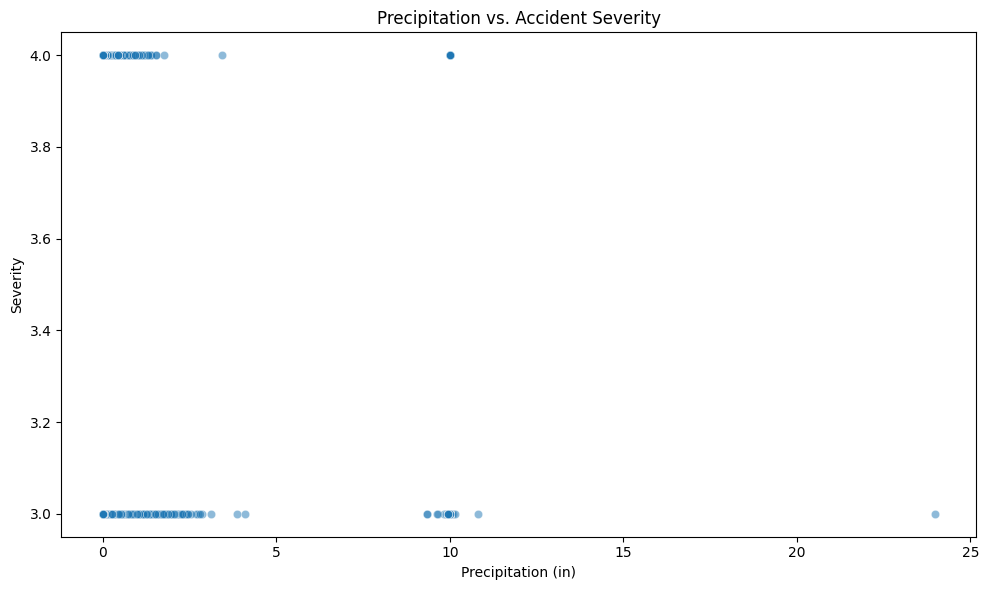

In [28]:
analyze_precipitation(df)
analyze_precipitation(df_severe)

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\1133580554.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_speed_severity = df.groupby(pd.cut(df['Wind_Speed(mph)'], bins=[0, 5, 10, 15, 20, 30])).Severity.mean()


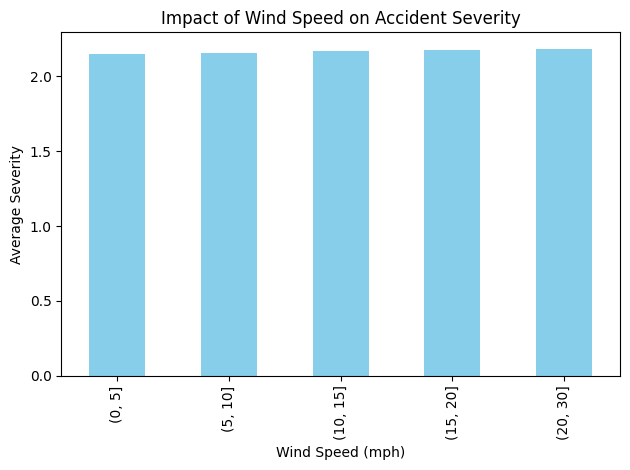

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\1133580554.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_speed_severity = df.groupby(pd.cut(df['Wind_Speed(mph)'], bins=[0, 5, 10, 15, 20, 30])).Severity.mean()


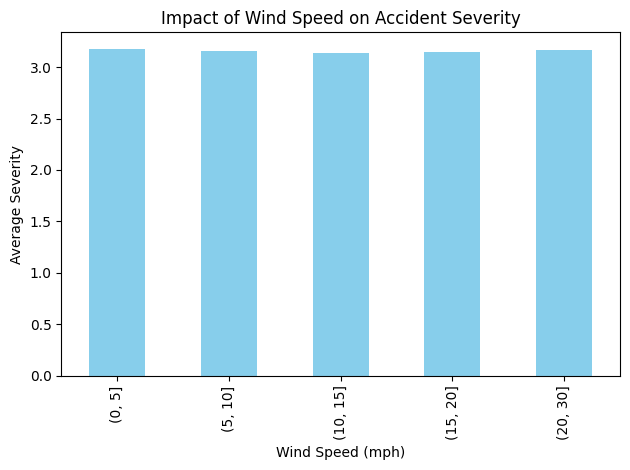

In [29]:
wind_speed_analysis(df)
wind_speed_analysis(df_severe)

c:\Users\bisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\bisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


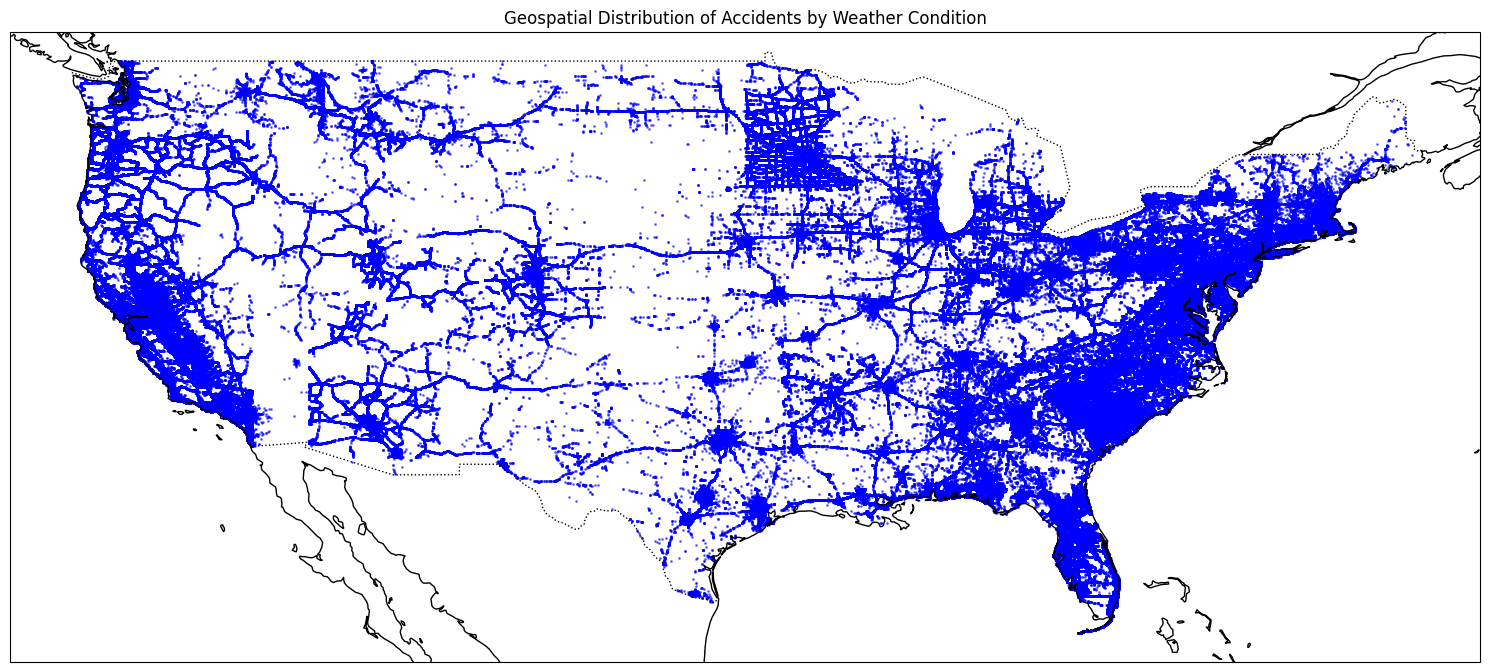

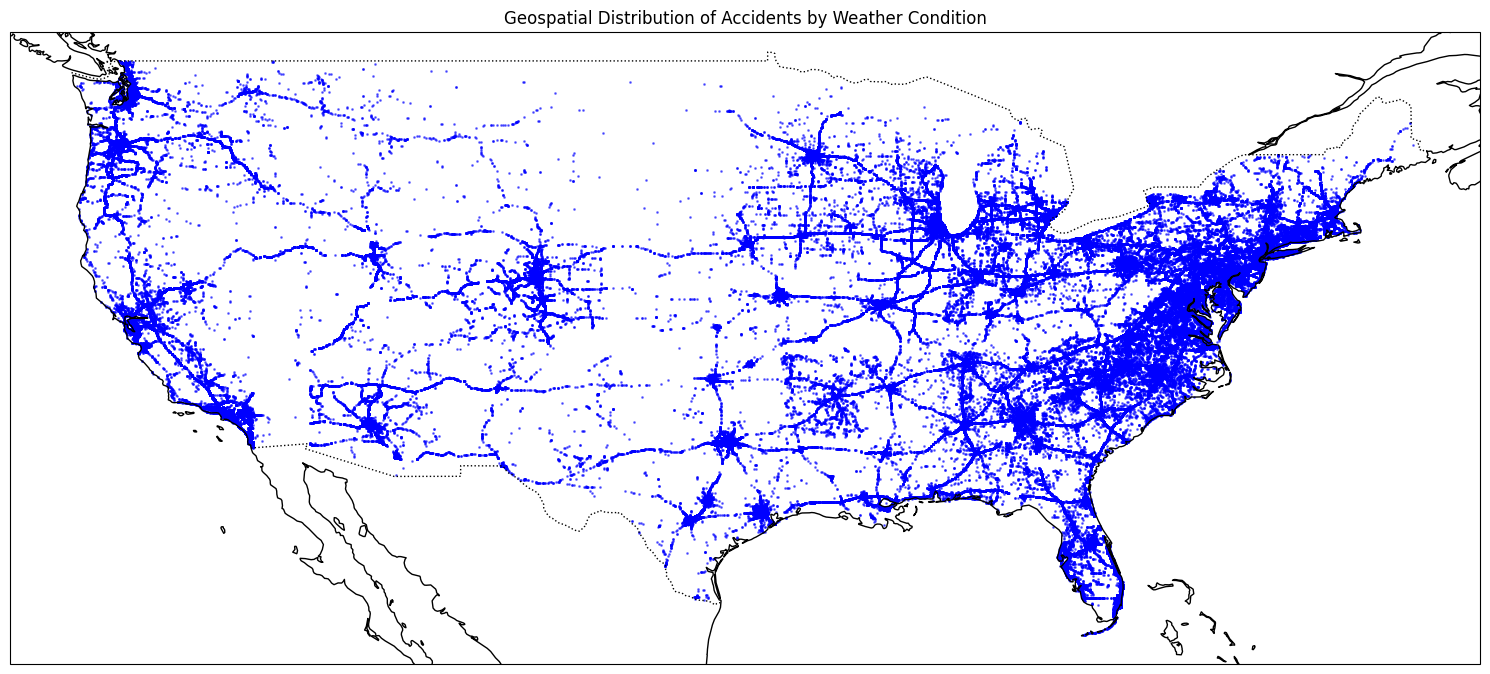

In [30]:
map_weather_conditions(df)
map_weather_conditions(df_severe)

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\1025870147.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = pd.to_datetime(df['Start_Time']).dt.month


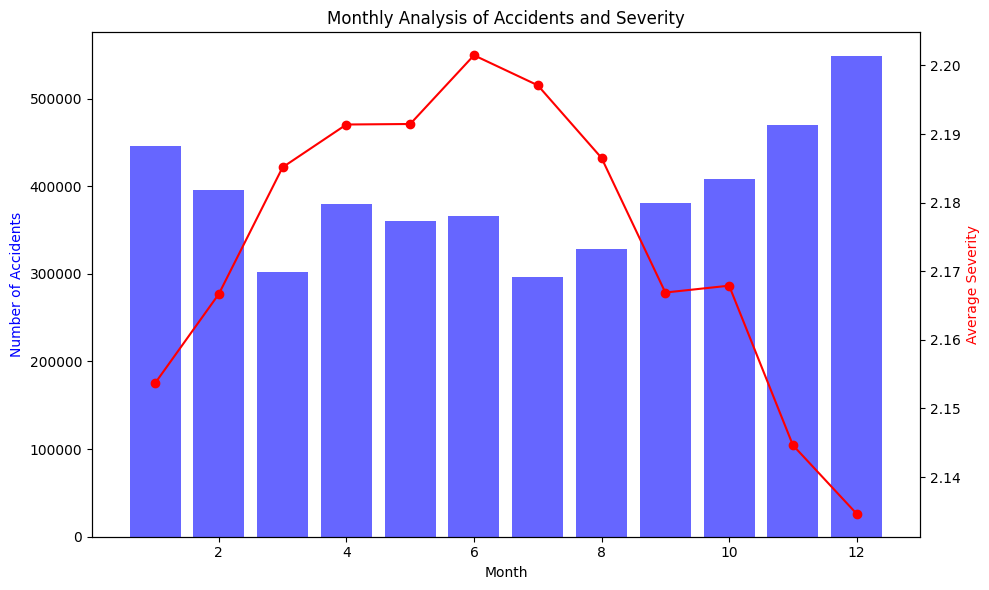

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\1025870147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\1025870147.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = pd.to_datetime(df['Start_Time']).dt.month


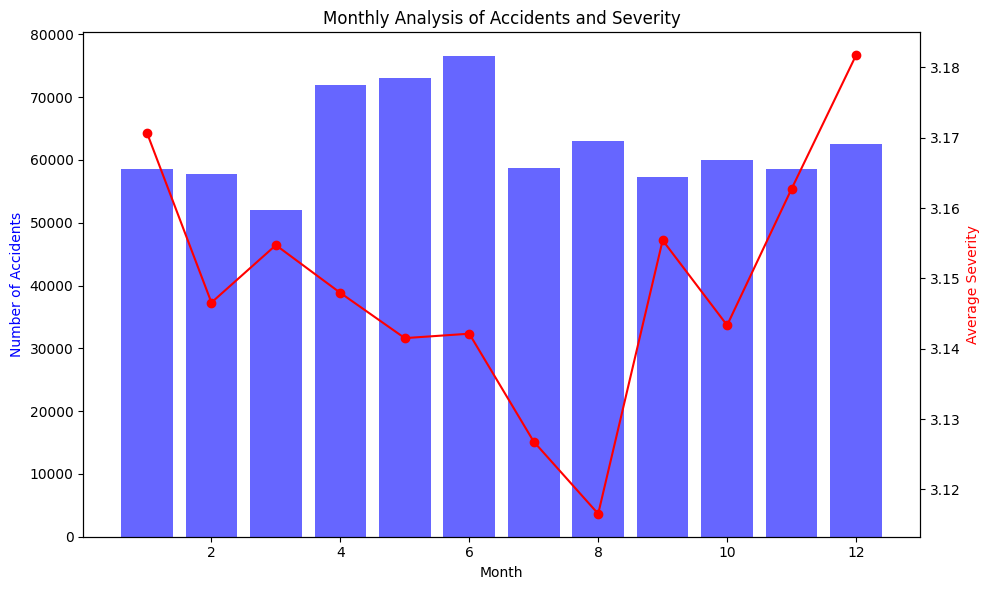

In [31]:
analyze_monthly_accidents(df)
analyze_monthly_accidents(df_severe)

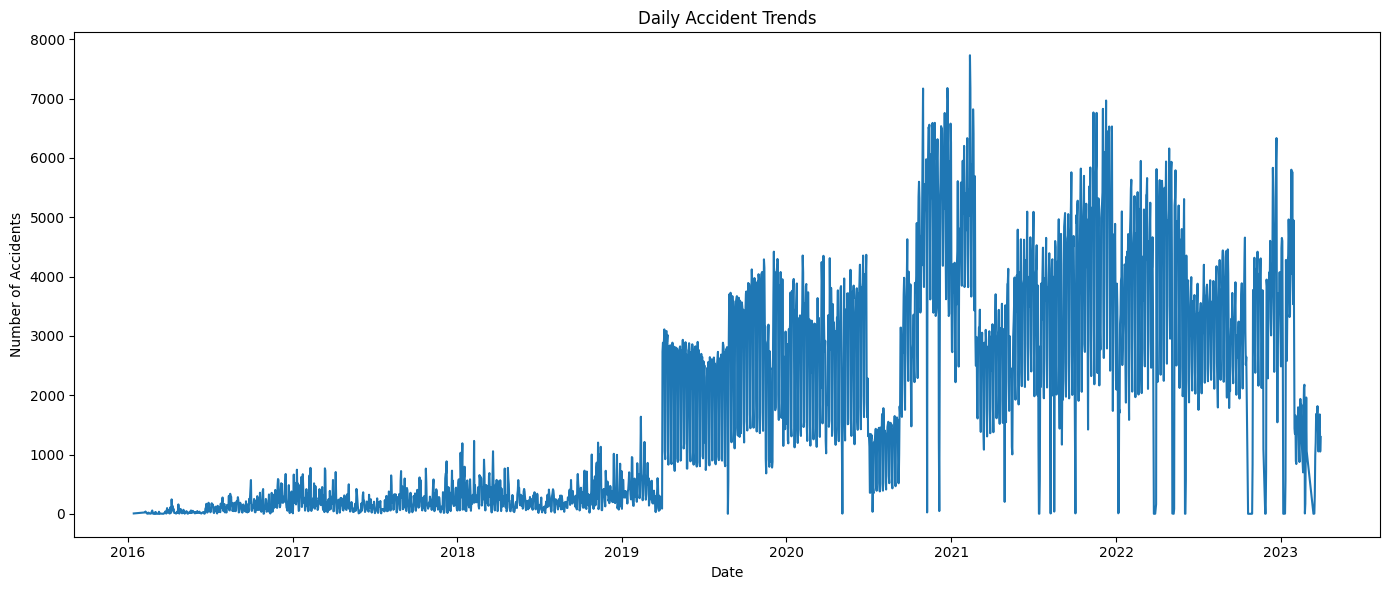

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\4023222168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Start_Time']).dt.date


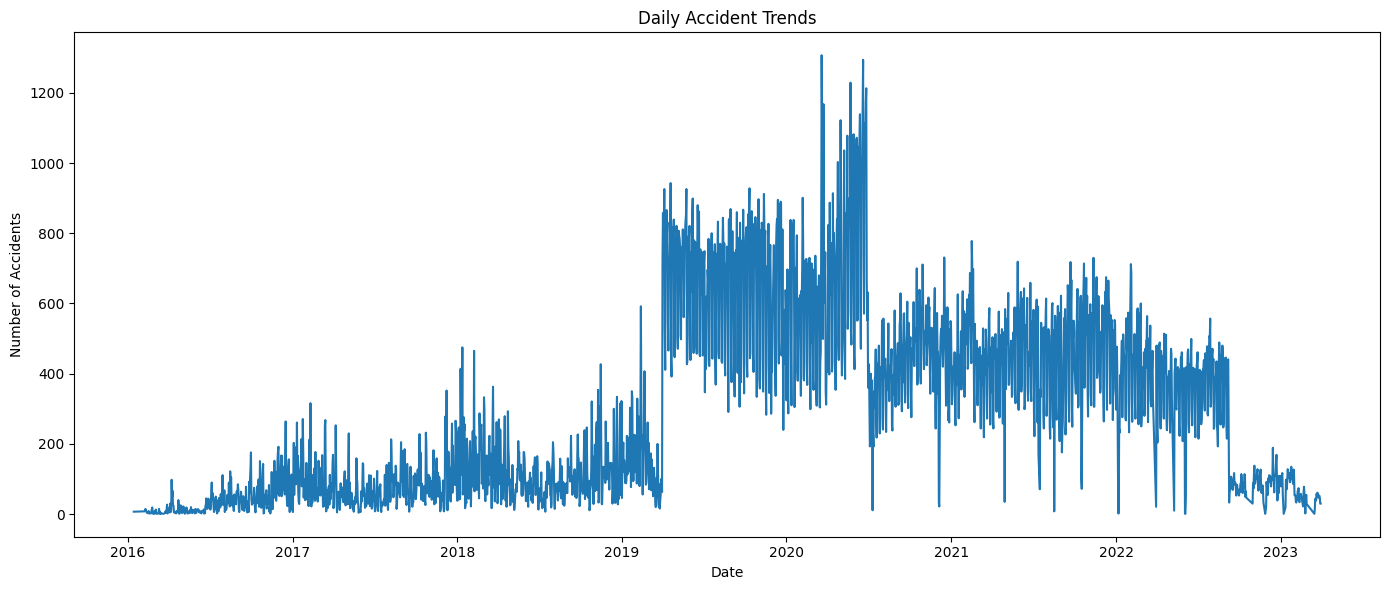

In [32]:
daily_accident_trends(df)
daily_accident_trends(df_severe)

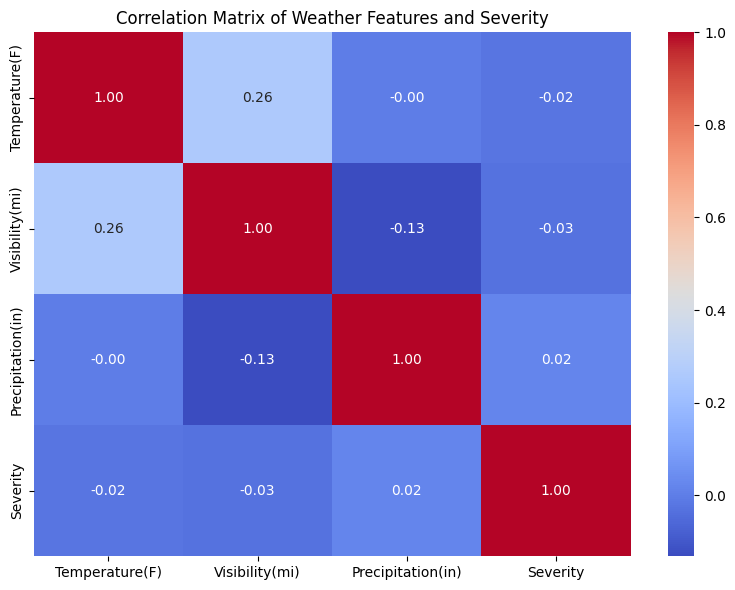

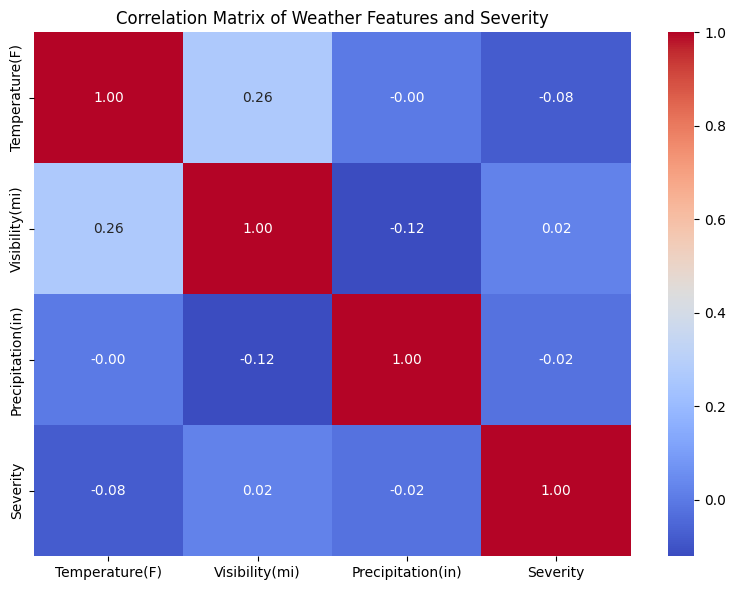

In [33]:
weather_correlation_matrix(df)
weather_correlation_matrix(df_severe)

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\1462303618.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\bisha\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


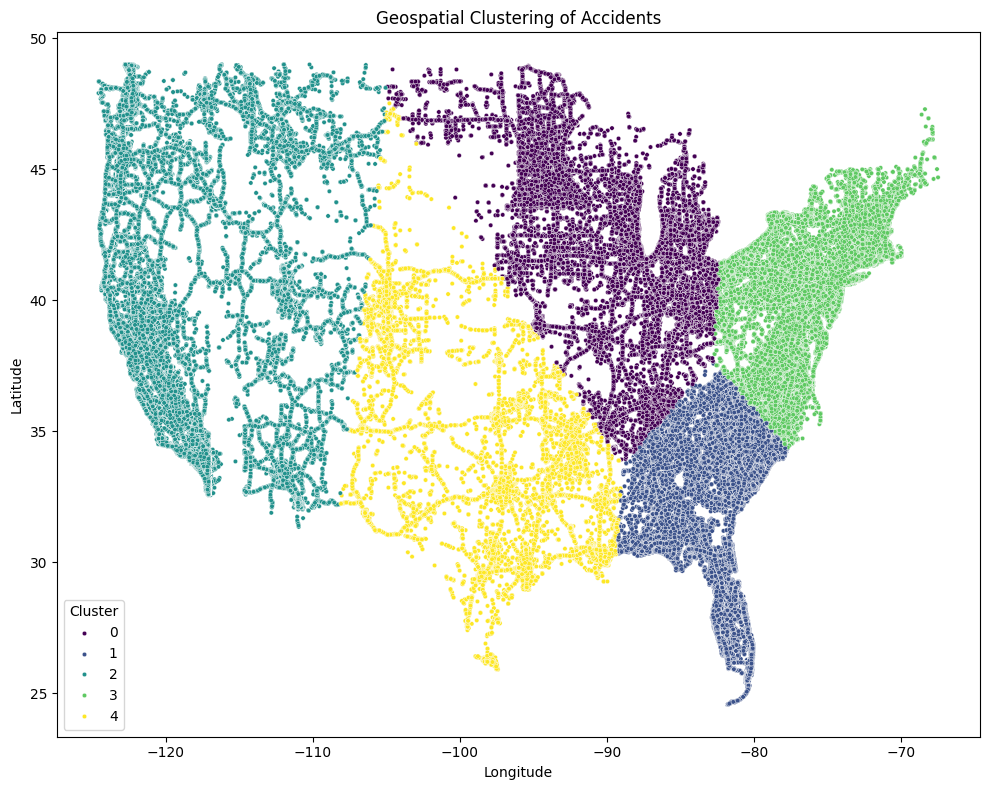

C:\Users\bisha\AppData\Local\Temp\ipykernel_20324\1462303618.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = clusters


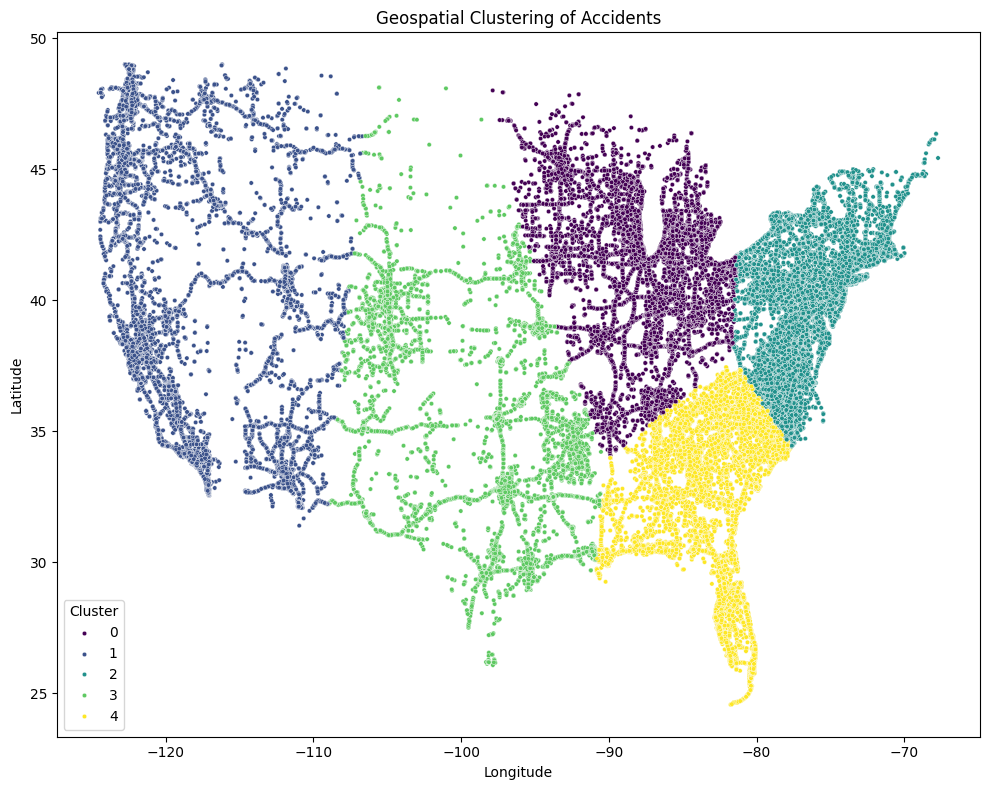

In [34]:
geospatial_clustering(df)
geospatial_clustering(df_severe)

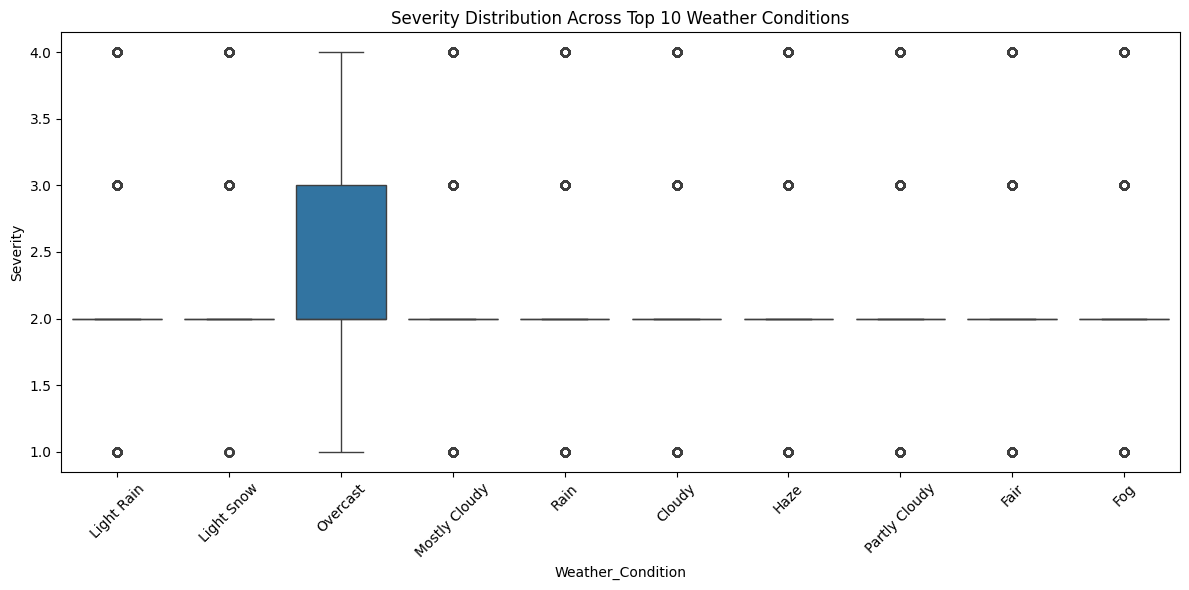

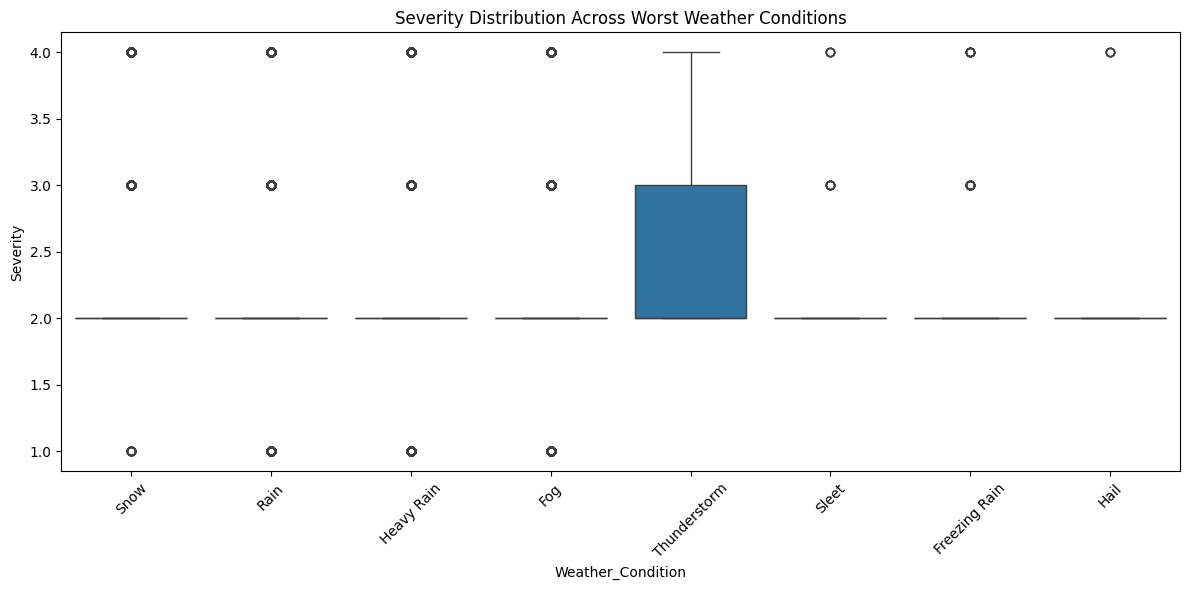

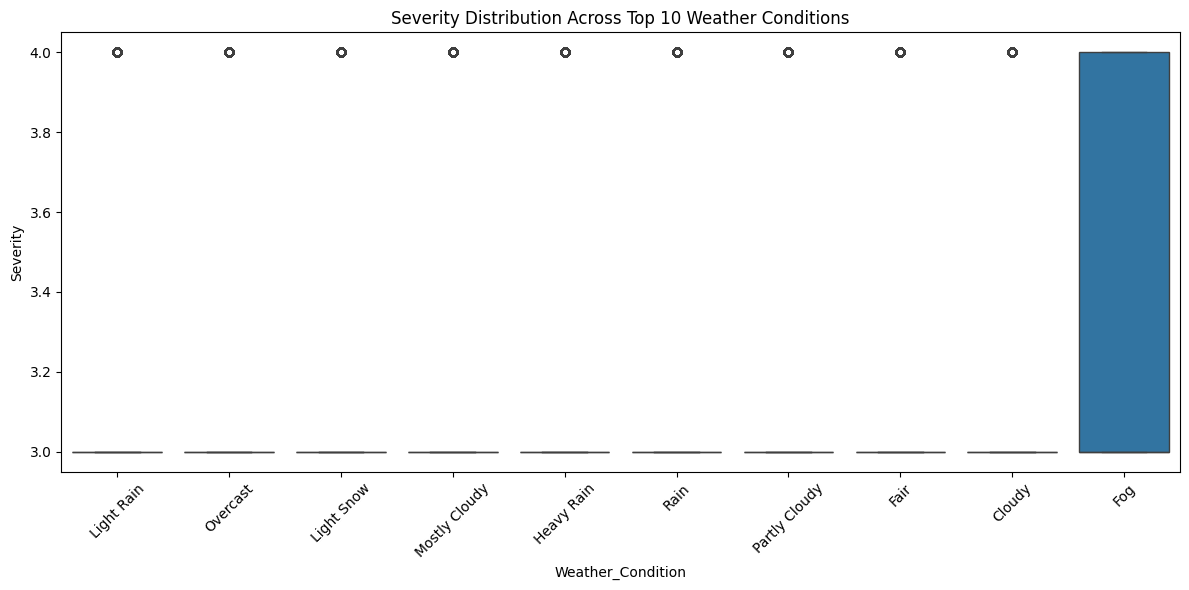

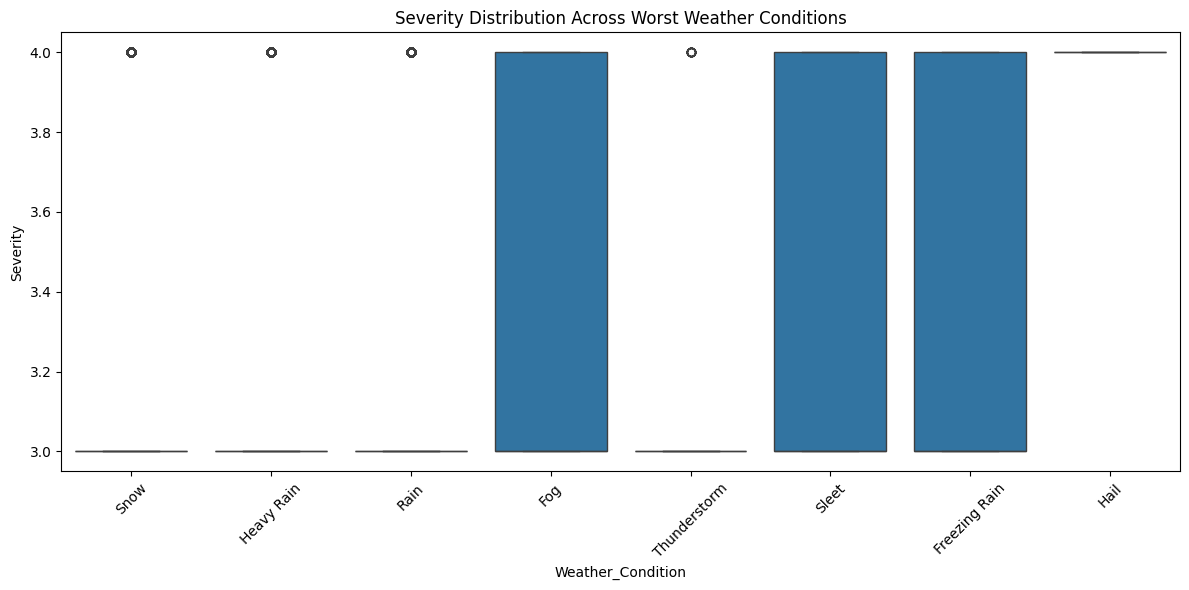

In [35]:
boxplot_weather_severity(df)
boxplot_worst_weather_severity(df)

boxplot_weather_severity(df_severe)
boxplot_worst_weather_severity(df_severe)

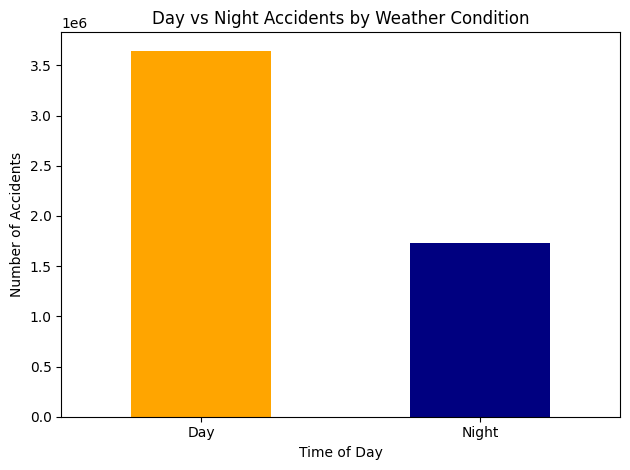

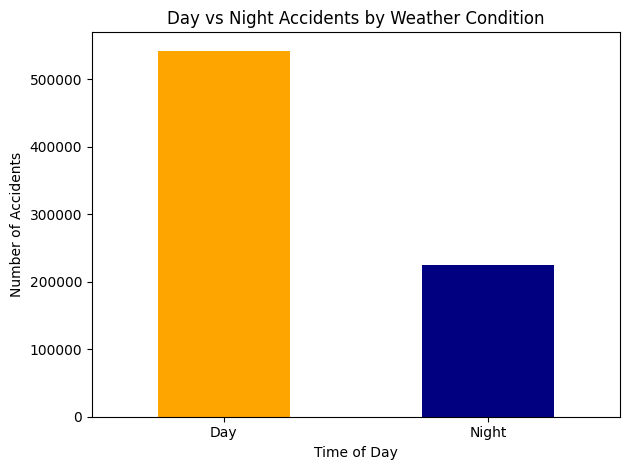

In [36]:
day_night_accident_comparison(df)
day_night_accident_comparison(df_severe)

<Figure size 1000x700 with 0 Axes>

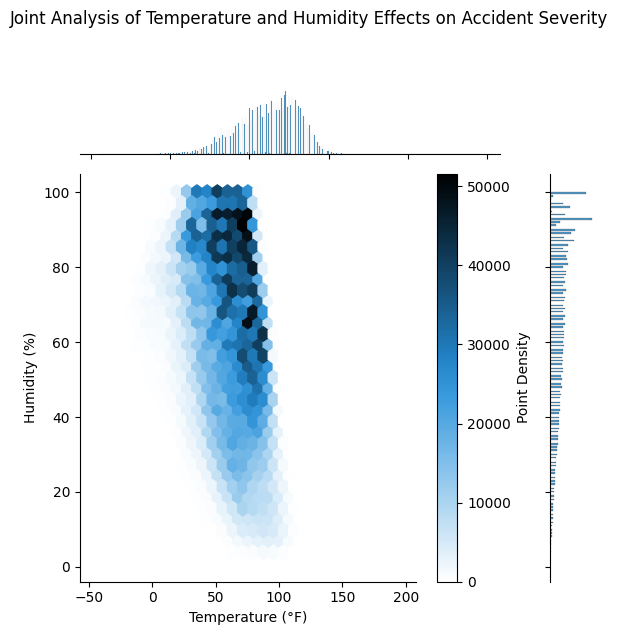

<Figure size 1000x700 with 0 Axes>

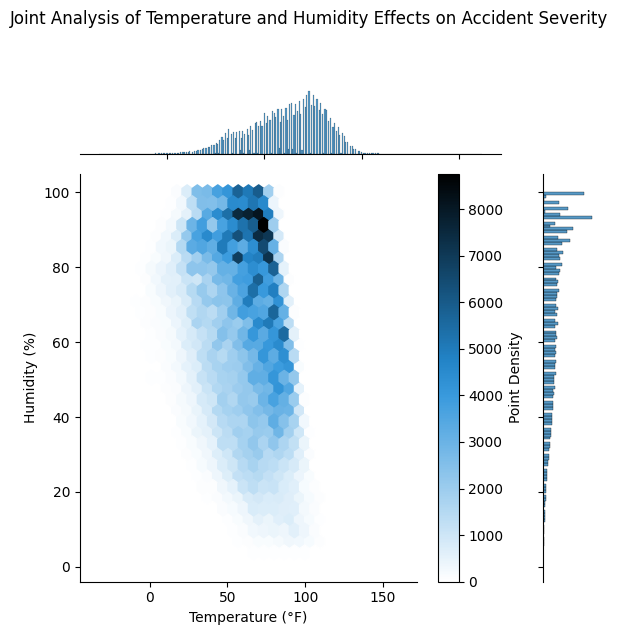

In [37]:
temperature_humidity_interaction(df)
temperature_humidity_interaction(df_severe)

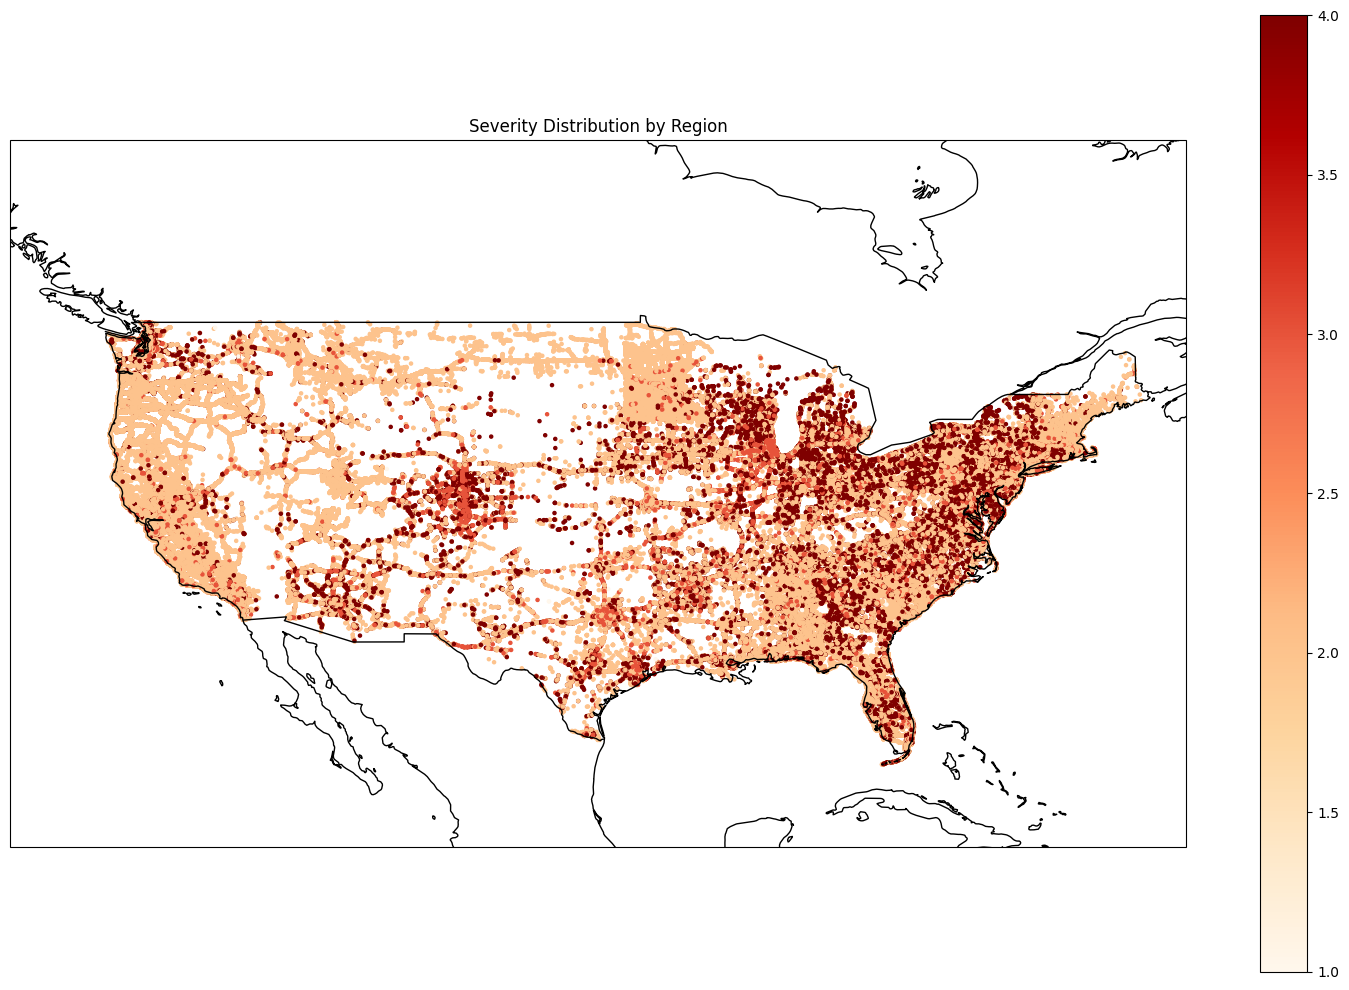

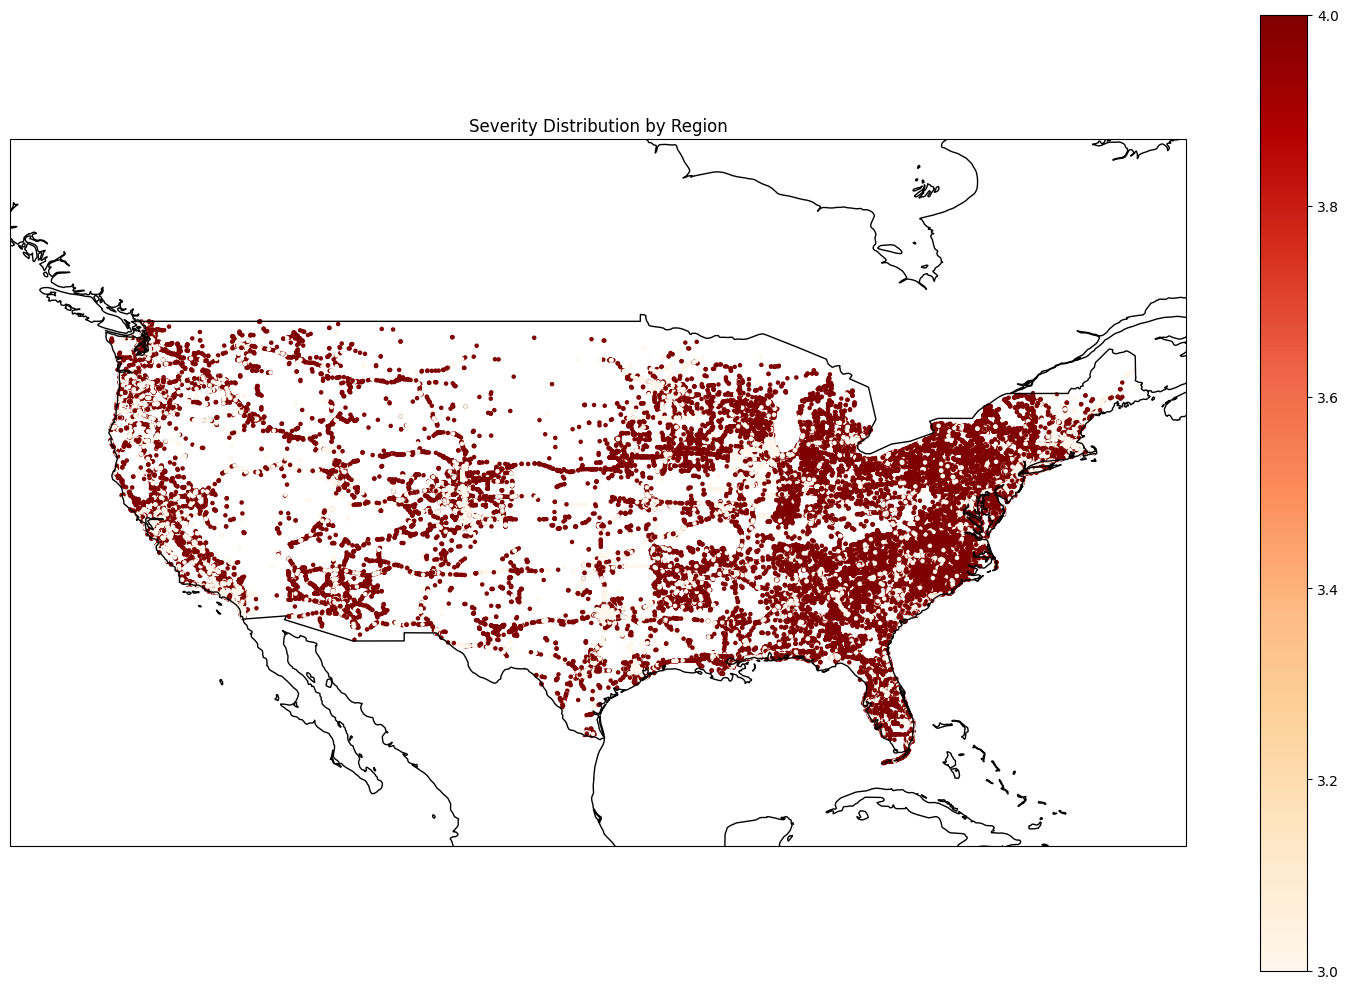

In [38]:
severity_distribution_map(df)
severity_distribution_map(df_severe)